Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# LAB9

Write a local-search algorithm (eg. an EA) able to solve the *Problem* instances 1, 2, 5, and 10 on a 1000-loci genomes, using a minimum number of fitness calls. That's all.

### Deadlines:

* Submission: Sunday, December 3 ([CET](https://www.timeanddate.com/time/zones/cet))
* Reviews: Sunday, December 10 ([CET](https://www.timeanddate.com/time/zones/cet))

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

In [318]:
import lab9_lib

from random import choices, randint, choice, random
from dataclasses import dataclass
from copy import copy, deepcopy

In [319]:
TOURNAMENT_SIZE = 3
MUTATION_PROBABILITY = 0.10
POPULATION_SIZE = 70 # POPULATION_SIZE = 7 * OFFSPRING_SIZE
PROBLEM_DIMENSIONS = [1, 2, 5, 10]
GENOTYPES_LENGTH = 1000
OFFSPRING_SIZE = 10

In [320]:
@dataclass
class Individual:
    genotype: list[int]
    fitness: float
    

def create_population():
    population = [
                Individual(
                    genotype=choices([0, 1], k = GENOTYPES_LENGTH),
                    fitness=None,
                )
                for _ in range(POPULATION_SIZE)
            ]
    
    return population

def create_initial_genotype():
    genotype = Individual(
        genotype=choices([0, 1], k = GENOTYPES_LENGTH),
        fitness=None,
    )    
    return genotype


def select_parent(pop):
    pool=[choice(pop) for _ in range(TOURNAMENT_SIZE)]
    champion = max(pool, key=lambda i: i.fitness)
    return champion


def mutate(ind: Individual) -> Individual:
    offspring = copy(ind)

    pos = randint(0, GENOTYPES_LENGTH - 1)
    offspring.genotype[pos] = 1 - offspring.genotype[pos]

    return offspring

def one_cut_cover(ind1: Individual,ind2: Individual) ->Individual:
    cut_point=randint(0,GENOTYPES_LENGTH-1)
    offspring=Individual(fitness=None,genotype=ind1.genotype[:cut_point]+ind2.genotype[cut_point:])
    assert len(offspring.genotype) == GENOTYPES_LENGTH
    return offspring


Problem Dimension: 1, initial fitness: 52.90% -> final fitness: 97.20%
Number of fitness calls: 50070

Problem Dimension: 2, initial fitness: 51.80% -> final fitness: 74.80%
Number of fitness calls: 50070

Problem Dimension: 5, initial fitness: 29.51% -> final fitness: 32.64%
Number of fitness calls: 50070

Problem Dimension: 10, initial fitness: 15.97% -> final fitness: 26.45%
Number of fitness calls: 50070



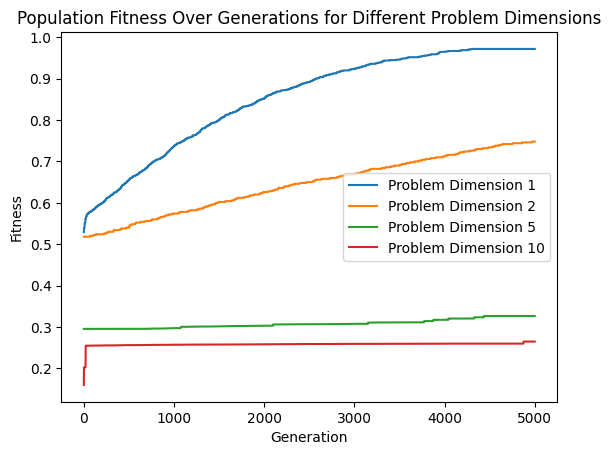

In [322]:
import matplotlib.pyplot as plt
from copy import deepcopy
from random import random

def population_function(problem_dimension, initial_population, iterations):
    fitness = lab9_lib.make_problem(problem_dimension)
    population = deepcopy(initial_population)

    for i in population:
        i.fitness = fitness(i.genotype)

    population.sort(key=lambda i: i.fitness, reverse=True)
    initial_fitness = population[0].fitness

    fitness_over_generations = [initial_fitness]

    for _ in range(iterations):
        offspring = list()

        for counter in range(OFFSPRING_SIZE):
            if random() < MUTATION_PROBABILITY:
                p = select_parent(population)
                o = mutate(p)
            else:
                p1 = select_parent(population)
                p2 = select_parent(population)
                o = one_cut_cover(p1, p2)

            offspring.append(o)

        for i in offspring:
            i.fitness = fitness(i.genotype)

        population.extend(offspring)
        population.sort(key=lambda i: i.fitness, reverse=True)
        population = population[:POPULATION_SIZE]

        fitness_over_generations.append(population[0].fitness)

    print(f"Problem Dimension: {problem_dimension}, initial fitness: {initial_fitness:.2%} -> final fitness: {population[0].fitness:.2%}")
    print(f"Number of fitness calls: {fitness.calls}\n")

    plt.plot(range(iterations + 1), fitness_over_generations, label=f"Problem Dimension {problem_dimension}")


for problem_dimension in PROBLEM_DIMENSIONS:
    initial_population = create_population()
    population_function(problem_dimension, initial_population, iterations=5000) 
plt.title("Population Fitness Over Generations for Different Problem Dimensions")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend()
plt.show()
